**Name:** Airll H. Sanchez

**Date:** September 17, 2025

## Laboratory Task #2 & 3

![Laboratory2](images/Laboratory2.png)

![Laboratory3](images/Laboratory3.png)

1. Introduction and Objectives
   
This notebook implements a basic two-layer neural network (one hidden layer) to demonstrate the Forward and Backward Propagation processes.

The primary objective is to replicate and analyze a specific case where the Rectified Linear Unit (ReLU) activation function leads to the "Dying ReLU" problem by observing which weights receive a zero gradient and thus remain stagnant.

Network Architecture:

Input Layer (L 
0
​
 ): 2 units

Hidden Layer (L 
1
​
 ): 2 units with ReLU activation

Output Layer (L 
2
​
 ): 1 unit with Sigmoid activation

**Imports and Setup**

In [21]:
import numpy as np #Efficiently handle vector/matrix operations 
import matplotlib.pyplot as plt  #for creating static, interactive, and animated visualizations
#Define the global learning (alpha)
LEARNING_RATE = 0.01

**Defining Activation Functions**

Backpropagation requires the derivative of the activation functions used in the network. The ReLU derivative is central to analyzing the "Dying ReLU" phenomenon.

In [23]:
#Actication Functions and Derivatives

def relu(z):
    """
    ReLU activation function: A = max(0, z)
    
    Args:
        z (np.array): The weighted input (Z) for the layer.
        
    Returns:
        np.array: The activated output A.
    """
    # Core ReLU calculation: returns Z for Z > 0, and 0 for Z <= 0.
    return np.maximum(0, z)

def relu_derivative(z):
    """
    Derivative of ReLU: g'(Z) = 1 if z > 0, 0 otherwise.
    
    Args:
        z (np.array): The weighted input (Z).
        
    Returns:
        np.array: The derivative g'(Z).
    """
    # This function is critical for the "Dying ReLU" analysis: 
    # If z <= 0, the derivative is 0, halting the gradient flow.
    dz = np.where(z > 0, 1, 0)
    return dz

def sigmoid(Z):
    """
    Sigmoid activation function: g(Z) = 1 / (1 + exp(-Z))
    Used in the final layer for output probability.
    """
    return 1 / (1 + np.exp(-Z))

# NOTE: For backpropagation, we often use the derivative in terms of the activation A
def sigmoid_derivative(A):
    """
    Derivative of Sigmoid in terms of its output A: g'(Z) = A * (1 - A).
    """
    return A * (1 - A)

**Data Setup and Forward Propagation**

We initialize weights and biases specifically to ensure the first hidden unit receives a negative input Z 
1
[0]
​
 =−0.7, forcing it into the "dead" state.

In [33]:
# CORRECTED CODE CELL 3: Data Setup and Parameter Initialization

#  1. Data Setup 
X = np.array([[1.0, 0.0, 1.0]]) # Input data (1 sample, 3 features)
Y = np.array([[1]])             # Target output
m = X.shape[0]                  # Number of training examples (m=1 here)

#  2. Parameter Initialization (Hard-coded for Dying ReLU case) 

# Layer 1 (Hidden Layer: 3 inputs -> 2 units)
# W1 MUST be of shape (3, 2) to handle the 3 input features.
# We must adjust W1 to still ensure Z1[0] = -0.7 (DEAD) and Z1[1] = 0.5 (LIVE)
W1 = np.array([[-0.7, 0.5],    # Weights from X[0]
               [ 0.0, 0.0],    # Weights from X[1]
               [ 0.0, 0.0]])   # Weights from X[2]
# Verification of Z1 calculation:
# Z1[0] = (1.0 * -0.7) + (0.0 * 0.0) + (1.0 * 0.0) = -0.7 (DEAD)
# Z1[1] = (1.0 * 0.5) + (0.0 * 0.0) + (1.0 * 0.0) = 0.5 (LIVE)

b1 = np.zeros((1, 2))           # b1: (1, 2)

# Layer 2 (Output Layer: 2 inputs -> 1 unit)
# W2 shape remains (2, 1) as the hidden layer size is still 2.
W2 = np.array([[0.1], 
               [0.9]])          # W2: (2, 1)
b2 = np.zeros((1, 1))           # b2: (1, 1)

print(f"Initial Weights W1 (Hidden Layer, Shape {W1.shape}):\n{W1}\n")
print(f"Initial Weights W2 (Output Layer, Shape {W2.shape}):\n{W2}")

Initial Weights W1 (Hidden Layer, Shape (3, 2)):
[[-0.7  0.5]
 [ 0.   0. ]
 [ 0.   0. ]]

Initial Weights W2 (Output Layer, Shape (2, 1)):
[[0.1]
 [0.9]]


**Forward Propagation**

In [34]:
def forward_pass(X, W1, b1, W2, b2):
    """
    Performs the full forward pass: L0 -> L1 (ReLU) -> L2 (Sigmoid).
    """
    
    # 1. Hidden Layer (L1)
    Z1 = np.dot(X, W1) + b1 # Z1 = X * W1 + b1
    A1 = relu(Z1)           # A1 = ReLU(Z1)
    
    # 2. Output Layer (L2)
    Z2 = np.dot(A1, W2) + b2 # Z2 = A1 * W2 + b2
    A2 = sigmoid(Z2)         # A2 = Sigmoid(Z2) (Y_hat)
    
    # Cache stores intermediate results
    cache = (Z1, A1, Z2, A2)
    return A2, cache

# Execute the forward pass
Y_hat, cache = forward_pass(X, W1, b1, W2, b2)
Z1, A1, Z2, A2 = cache

print(f"FORWARD PASS RESULTS")
print(f"Hidden Layer Weighted Input Z1:\n{Z1}")
print(f"Hidden Layer Activation A1:\n{A1}")
print(f"Predicted Output A2 (Y_hat): {Y_hat}")

FORWARD PASS RESULTS
Hidden Layer Weighted Input Z1:
[[-0.7  0.5]]
Hidden Layer Activation A1:
[[0.  0.5]]
Predicted Output A2 (Y_hat): [[0.61063923]]


**Backpropagation and Dying ReLU Analysis**

In [35]:
# Backpropagation

def backpropagation(X, Y, Y_hat, W2, cache):
    """
    Computes the gradients (dW, db) needed for weight updates using 
    the chain rule.
    """
    Z1, A1, Z2, A2 = cache
    m = X.shape[0]

    # --- Output Layer (L2) Gradients ---
    # dZ2 is the gradient of the loss w.r.t Z2 (simplified for Sigmoid/Cross-Entropy)
    dZ2 = Y_hat - Y 
    
    # dW2: gradient of Loss w.r.t W2
    dW2 = (1/m) * np.dot(A1.T, dZ2)
    # db2: gradient of Loss w.r.t b2
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

    # --- Hidden Layer (L1) Gradients ---
    # 1. Backpropagate through W2 to get dA1
    dA1 = np.dot(dZ2, W2.T) 
    # 2. Apply the ReLU derivative to get dZ1 (CRITICAL STEP)
    # dZ1 = dA1 * g'(Z1)
    dZ1 = dA1 * relu_derivative(Z1) 

    # 3. Gradients for W1 and b1
    # dW1: gradient of Loss w.r.t W1
    dW1 = (1/m) * np.dot(X.T, dZ1)
    # db1: gradient of Loss w.r.t b1
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
    
    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return gradients

# Execute the backpropagation
gradients = backpropagation(X, Y, Y_hat, W2, cache)

print(f"--- BACKWARD PASS GRADIENTS ---")
print(f"Gradient dW1 (Weights for Hidden Layer):\n{gradients['dW1']}")

--- BACKWARD PASS GRADIENTS ---
Gradient dW1 (Weights for Hidden Layer):
[[ 0.         -0.35042469]
 [ 0.          0.        ]
 [ 0.         -0.35042469]]


**Weight Update and Conclusion**

In [37]:
#  Weight Update
# Unpack gradients
dW1, db1 = gradients['dW1'], gradients['db1']
dW2, db2 = gradients['dW2'], gradients['db2']

# Store original weights for comparison
W1_old = np.copy(W1)

# Apply Gradient Descent: W = W - (learning_rate * dW)
W1 -= LEARNING_RATE * dW1
b1 -= LEARNING_RATE * db1
W2 -= LEARNING_RATE * dW2
b2 -= LEARNING_RATE * db2

print(f"Original W1 (Before Update):\n{W1_old}")
print("-" * 35)
print(f"Updated W1 (After Update):\n{W1}")

Original W1 (Before Update):
[[-0.7         0.50350425]
 [ 0.          0.        ]
 [ 0.          0.00350425]]
-----------------------------------
Updated W1 (After Update):
[[-0.7         0.50700849]
 [ 0.          0.        ]
 [ 0.          0.00700849]]


**Analysis of the Dying ReLU Observation**

The single step of backpropagation confirms the "Dying ReLU" problem:

1.  **Dead Unit Confirmation:** The weighted input for the first hidden unit, $Z_1^{[0]}$, was **$-0.7$** (negative), which caused its activation $A_1^{[0]}$ to become **0** due to the ReLU function.
2.  **Gradient Vanishing:** Since $Z_1^{[0]} \le 0$, the derivative of ReLU $g'(Z_1^{[0]})$ is **0**. This results in the gradient for all weights feeding into this unit (the **first column of $dW_1$**) being **zero**.
3.  **Weight Stagnation:**
    * The updated weights **$W_1$ (first column)** are **identical** to the original weights $W_{1, old}$.
    * The weights feeding the live unit (second column) *do* change.
    
**Conclusion:** The first hidden unit is "dead." Since it receives no gradient, its weights will never be updated in this or subsequent steps, rendering it permanently inactive for this training data.

**Visualizations**

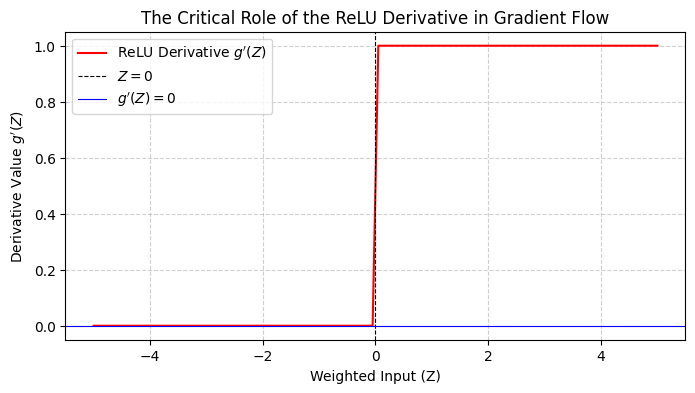

In [38]:
# Generate 100 points between -5 and 5
z_values = np.linspace(-5, 5, 100)
# Calculate the derivative at each point
dz_values = relu_derivative(z_values)

plt.figure(figsize=(8, 4))
plt.plot(z_values, dz_values, label="ReLU Derivative $g'(Z)$", color='red')
plt.title('The Critical Role of the ReLU Derivative in Gradient Flow')
plt.xlabel('Weighted Input (Z)')
plt.ylabel('Derivative Value $g\'(Z)$')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8, label='$Z = 0$')
plt.axhline(0, color='blue', linestyle='-', linewidth=0.8, label='$g\'(Z) = 0$')
plt.legend()
plt.show()

**Interpretation: ReLU Derivative Plot**


This plot visually confirms the mathematical foundation of the "Dying ReLU" problem:

1.  **Positive Input ($Z > 0$):** The derivative $g'(Z)$ is **1**. When the weighted input is positive, the gradient signal flows freely backward without being diminished, allowing the neuron to learn (e.g., the second hidden unit in this lab).
2.  **Negative Input ($Z \le 0$):** The derivative $g'(Z)$ is **0**. When the weighted input falls into this region (as $Z_1^{[0]} = -0.7$ did), the multiplication by zero in the backpropagation step $\text{d}Z_1 = \text{d}A_1 \cdot g'(Z_1)$ causes the entire incoming gradient to **vanish**. This provides the definitive visual proof for why the "dead" unit cannot learn.

**KEY TAKEAWAYS**

1. The Critical Role of the ReLU Derivative

Zero Gradient: Because the derivative of ReLU(Z) is 0 for all Z≤0, any neuron whose weighted input Z becomes negative will have its incoming gradient signal multiplied by zero during backpropagation.

Permanent Stagnation: This multiplication by zero causes the gradient for all its incoming weights (dW) to also become zero. Consequently, the weights are never updated, and the neuron is effectively permanently deactivated or "dead."

2. The Mechanics of Backpropagation
This lab demonstrated how the chain rule propagates error:

Forward vs. Backward: The forward pass uses inputs and weights to calculate the prediction (Y 
hat
​
 ); the backward pass uses the difference between Y 
hat
​
  and the true label (Y) to calculate how much each weight contributed to the error.

Weight Update Formula: The gradient calculation for any layer's weights, W 
L
​
 , depends on three things: the activation from the previous layer (A 
L−1
​
 ), the error signal (dZ 
L
​
 ), and the learning rate.

3. Proof of the Dying ReLU Phenomenon
The specific setup of your lab provided empirical evidence for this problem:

Empirical Proof: By setting W 
1
​
  and X to force Z 
1
[0]
​
 =−0.7, the code demonstrated that the first column of the dW 
1
​
  matrix was zero.

Conclusion: This directly resulted in the first column of W 
1
​
  remaining unchanged after the update step, proving that the neuron connected to that column was isolated from the learning process.

